In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import bloscpack as bp
%matplotlib inline

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

from registration_utilities import *
from annotation_utilities import *
from vis3d_utilities import *

Setting environment for Local Macbook Pro


Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/home/yuncong/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-N16-2015.07.16-20.32.33_MD585_2_0047_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD589/MD589_prep2_thumbnail/MD589-N16-2015.07.30-17.03.43_MD589_3_0048_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD590/MD590_prep2_thumbnail/MD590-IHC17-2015.08.10-19.09.09_MD590_2_0050_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD591/MD591_prep2_thumbnail/MD591-IHC17-2015.08.28-04.23.47_MD591_1_0049_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD592/MD592_prep2_thumbnail/MD592-N16-2015.08.22-00.50.39_MD592_2_0047_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD593/MD593_prep2_thumbnail/MD593-N15-2015.08.21-16.53.02_MD593_3_0045_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD594/MD594_prep2_thumbnail/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD595/MD595_prep2_thumbnail/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_prep2_thumbn

Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


/home/yuncong/CSHL_data_processed/MD642/MD642_prep2_thumbnail/MD642-N14-2017.01.18-16.25.58_MD642_2_0041_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD657/MD657_prep2_thumbnail/MD657-N13-2017.02.22-14.33.34_MD657_3_0039_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD658/MD658_prep2_thumbnail/MD658-N18-2017.03.31-17.34.22_MD658_2_0053_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD661/MD661_prep2_thumbnail/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/MD662/MD662_prep2_thumbnail/MD662&661-F35-2017.06.05-17.08.18_MD662_1_0103_prep2_thumbnail.tif
/home/yuncong/CSHL_data_processed/ChatCryoJane201710/ChatCryoJane201710_prep2_thumbnail_Ntb/ChatCryoJane201710_slide1-S1_prep2_thumbnail_Ntb.tif


In [2]:
atlas_name = 'atlasV5'
# atlasV6 added the outline; everything else is the same as atlasV5

In [3]:
stack_fixed = 'MD589'
stacks_moving = ['MD585', 'MD594']
warp_setting = 9

In [4]:
# ann_vol_bbox_rel2uncropped = DataManager.load_original_volume_bbox(stack=stack_fixed, volume_type='annotation', downscale=32)
# print 'annotation volume bbox (rel2uncropped):', ann_vol_bbox_rel2uncropped

# Compute mean positions

## Compute centroids of all instances of all structures in MD589 space

In [9]:
left_instance_vol = DataManager.load_transformed_volume(stack_m='MD585', vol_type_m='annotationAsScore',
                                                        stack_f='MD589', vol_type_f='annotationAsScore',
                                                        warp_setting=warp_setting,
                                                        structure='7N_L')

In [7]:
instance_centroids_rel2fixed = defaultdict(list)

# for name_u in ['7N']:
for name_u in all_known_structures:
    print name_u
    
    if name_u in paired_structures:
        lname = convert_to_left_name(name_u)
        rname = convert_to_right_name(name_u)
    else:
        lname = name_u
        rname = name_u
    
    try:
        right_instance_vol = DataManager.load_original_volume(stack=stack_fixed,  downscale=32, volume_type='annotationAsScore', structure=rname)
        right_instance_vol_bbox = np.array(bbox_3d(right_instance_vol))
        right_instance_vol_inbbox = crop_and_pad_volume(right_instance_vol, out_bbox=right_instance_vol_bbox)
        
        instance_centroid_rel2fixed = np.mean(np.nonzero(right_instance_vol_inbbox), axis=1)[[1,0,2]] + right_instance_vol_bbox[[0,2,4]]
        instance_centroids_rel2fixed[rname].append(instance_centroid_rel2fixed)
        
    except Exception as e:
        print e
        continue

    try:
        left_instance_vol = DataManager.load_original_volume(stack=stack_fixed, downscale=32, volume_type='annotationAsScore', structure=lname)
        left_instance_vol_bbox = np.array(bbox_3d(left_instance_vol))
        left_instance_vol_inbbox = crop_and_pad_volume(left_instance_vol, out_bbox=left_instance_vol_bbox)
        
        instance_centroid_rel2fixed = np.mean(np.nonzero(left_instance_vol_inbbox), axis=1)[[1,0,2]] + left_instance_vol_bbox[[0,2,4]]
        instance_centroids_rel2fixed[lname].append(instance_centroid_rel2fixed)

    except Exception as e:
        print e
        continue        

    for stack_moving in stacks_moving:

        try:
            left_instance_vol = DataManager.load_transformed_volume(stack_m=stack_moving, vol_type_m='annotationAsScore',
                                                            stack_f=stack_fixed, vol_type_f='annotationAsScore',
                                                            warp_setting=warp_setting,
                                                            structure=lname)
            left_instance_vol_bbox_rel2fixed = DataManager.load_transformed_volume_bbox(stack_m=stack_moving, vol_type_m='annotationAsScore',
                                                        stack_f=stack_fixed, vol_type_f='annotationAsScore',
                                                        warp_setting=warp_setting,
                                                        structure=lname)
            instance_centroid_rel2fixed = np.mean(np.nonzero(left_instance_vol), axis=1)[[1,0,2]] + left_instance_vol_bbox_rel2fixed[[0,2,4]]
            instance_centroids_rel2fixed[lname].append(instance_centroid_rel2fixed)
        except Exception as e:
            print e
            continue 

        try:
            right_instance_vol = DataManager.load_transformed_volume(stack_m=stack_moving, vol_type_m='annotationAsScore',
                                                        stack_f=stack_fixed, vol_type_f='annotationAsScore',
                                                        warp_setting=warp_setting,
                                                        structure=rname)
            right_instance_vol_bbox_rel2fixed = DataManager.load_transformed_volume_bbox(stack_m=stack_moving, vol_type_m='annotationAsScore',
                                                        stack_f=stack_fixed, vol_type_f='annotationAsScore',
                                                        warp_setting=warp_setting,
                                                        structure=rname)
            instance_centroid_rel2fixed = np.mean(np.nonzero(right_instance_vol), axis=1)[[1,0,2]] + right_instance_vol_bbox_rel2fixed[[0,2,4]]
            instance_centroids_rel2fixed[rname].append(instance_centroid_rel2fixed)
        except Exception as e:
            print e
            continue 


5N
6N
7N
7n
Amb
LC
LRt
Pn
Tz
VLL
RMC
SNC
SNR
3N
4N
Sp5I
Sp5O
Sp5C
rm -rf "/home/yuncong/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume_Sp5C_R.bp" && mkdir -p "/home/yuncong/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume/score_volumes"
aws s3 cp "s3://mousebrainatlas-data/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume_Sp5C_R.bp" "/home/yuncong/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume_Sp5C_R.bp"


File does not exist: /home/yuncong/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume_Sp5C_R.bp


[Errno 2] No such file or directory: '/home/yuncong/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_warp9_MD589_down32_annotationAsScoreVolume_Sp5C_R.bp'
PBG
10N
VCA
VCP
DC
AP
12N
RtTg
SC
IC


In [9]:
instance_centroids_rel2fixed.default_factory = None

In [42]:
fp = DataManager.get_instance_centroids_filepath(atlas_name=atlas_name)
save_pickle(instance_centroids_rel2fixed, fp)
upload_to_s3(fp)

aws s3 cp "/home/yuncong/CSHL_meshes/atlasV5/atlasV5_instanceCentroids.pkl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV5/atlasV5_instanceCentroids.pkl"


## Load instance centroids

In [5]:
fp = DataManager.get_instance_centroids_filepath(atlas_name=atlas_name)
instance_centroids_rel2fixed = load_pickle(fp)

In [18]:
instance_centroids_rel2canon = {name_s: np.array(instance_centroids) - canonical_centroid_rel2fixed
                                for name_s, instance_centroids in instance_centroids_rel2fixed.iteritems()}

## Average the centroids

In [28]:
nominal_locations_rel2canon, canonical_centroid_rel2fixed, canonical_normal = \
average_location(instance_centroids_rel2fixed)

canonical_centroid_rel2uncropped = canonical_centroid_rel2fixed + ann_vol_bbox_rel2uncropped[[0,2,4]]
print 'canonical_centroid_rel2uncropped', canonical_centroid_rel2uncropped

[ 0.04111027 -0.09160432  0.99494653] @ [ 172.0630378   223.21016434  186.74030921]
canonical_centroid_rel2uncropped [ 794.0630378   378.21016434  314.74030921]


In [29]:
nominal_locations_rel2fixed = {k: canonical_centroid_rel2fixed + c for k, c in nominal_locations_rel2canon.iteritems()}

In [30]:
print 'deviation angle:', np.rad2deg(np.arccos(canonical_normal[2]))

deviation angle: 5.76256199381


In [31]:
cov_mat_allStructures, radii_allStructures, ellipsoid_matrix_allStructures = \
compute_covar_from_instance_centroids(instance_centroids_rel2fixed)

In [32]:
# Manually coerce 2D ellipsoid to 3D.

for k in sorted(all_known_structures_sided):
    orig_radii = radii_allStructures[k]
    new_radii = orig_radii.copy()
    new_radii[2] = 5 # manually assign a radius on the third direction.
    D = np.diag(new_radii)
    cov_mat_allStructures[k] = np.dot(ellipsoid_matrix_allStructures[k].T, np.dot(D**2, ellipsoid_matrix_allStructures[k]))

In [33]:
cov_mat_allStructures

{'10N_L': array([[   8.73503513,   28.67689077,   -0.32127121],
        [  28.67689077,  108.09691627,    6.50678922],
        [  -0.32127121,    6.50678922,   25.25767098]]),
 '10N_R': array([[ 18.24424834,   6.63761667,   8.19284956],
        [  6.63761667,  15.8003681 ,  -6.71678288],
        [  8.19284956,  -6.71678288,  14.4010548 ]]),
 '12N': array([[  4.16596794,  11.00546909,  -3.31957821],
        [ 11.00546909,  45.14741041,   3.13432629],
        [ -3.31957821,   3.13432629,  24.54451573]]),
 '3N_L': array([[ 212.28876163,  -58.51397998,  -70.67979921],
        [ -58.51397998,   16.57854198,   16.87522644],
        [ -70.67979921,   16.87522644,   50.65806766]]),
 '3N_R': array([[ 319.89624224,  -50.62728246,  -96.89380857],
        [ -50.62728246,    9.06947695,   10.45964232],
        [ -96.89380857,   10.45964232,   55.28772388]]),
 '4N_L': array([[ 185.44010244,  -28.57342117,  -74.21602692],
        [ -28.57342117,    4.86608743,    9.28532832],
        [ -74.21602692, 

In [34]:
for s, cov_mat in cov_mat_allStructures.iteritems():
    covar_fp = DataManager.get_prior_covariance_matrix_filepath(atlas_name=atlas_name, structure=s)
    create_parent_dir_if_not_exists(covar_fp)
    bp.pack_ndarray_file(cov_mat, covar_fp)

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


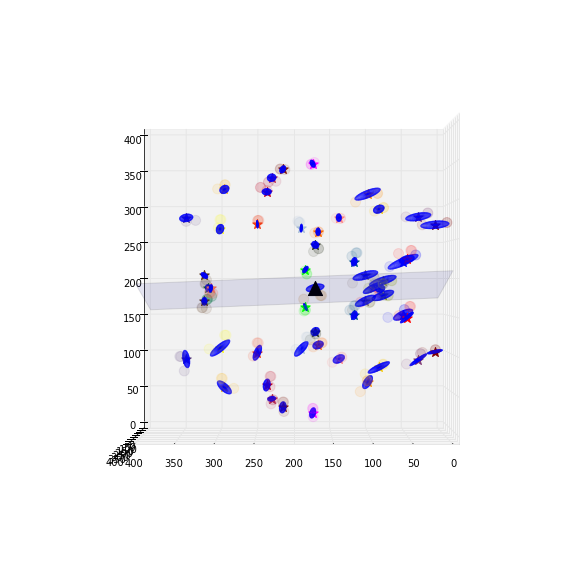

In [42]:
plot_centroid_means_and_covars_3d(
    instance_centroids=instance_centroids_rel2canon, 
    cov_mat_allStructures=cov_mat_allStructures,
                                  nominal_locations=nominal_locations_rel2canon,
                                  canonical_centroid=canonical_centroid_rel2fixed,
                                 canonical_normal=canonical_normal,
    colors={name_s: np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255.
            for name_s in nominal_locations_rel2canon.keys()})

In [51]:
np.savetxt(DataManager.get_atlas_canonical_centroid_filepath(atlas_name=atlas_name), canonical_centroid_rel2uncropped)
np.savetxt(DataManager.get_atlas_canonical_normal_filepath(atlas_name=atlas_name), canonical_normal)
save_pickle(nominal_locations_rel2canon, DataManager.get_structure_mean_positions_filepath(atlas_name=atlas_name))

# Compute mean shapes

In [43]:
stack_fixed = 'MD589'
stacks_moving = ['MD585', 'MD594']
warp_setting = 9

In [ ]:
instance_volumes = defaultdict(list)
instance_source = defaultdict(list)

moving_vol_aligned2template_inbbox_allInstances_allStructures = defaultdict(list)
moving_vol_aligned2template_bbox_rel2templateCentroid_allInstances_allStructures = defaultdict(list)
scores_allInstances_allStructures = defaultdict(list)
scores_allInstances_allStructures_allLearningRates = defaultdict(lambda: defaultdict(list))

structure_mean_shape_allStructures = {}
structure_origin_rel2templateCentroid_allStructures = {}
structure_mean_mesh_rel2templateCentroid_allStructures = {}

instance_aligned2template_meshes_rel2templateCentroid_allStructures = defaultdict(list)
template_meshes_rel2templateCentroid_allStructures = {}
template_vol_centroids_rel2template_allStructures = {}

# for name_u in ['7N']:
for name_u in all_known_structures:
    print name_u
    
    if name_u in paired_structures:
        lname = convert_to_left_name(name_u)
        rname = convert_to_right_name(name_u)
    else:
        lname = name_u
        rname = name_u
    
    try:
        right_instance_vol = DataManager.load_original_volume(stack=stack_fixed,  downscale=32, volume_type='annotationAsScore', structure=rname)
        right_instance_vol_bbox = np.array(bbox_3d(right_instance_vol))
        right_instance_vol_inbbox = crop_and_pad_volume(right_instance_vol, out_bbox=right_instance_vol_bbox)
        instance_volumes[name_u].append(right_instance_vol_inbbox) # if right, do not mirror
        instance_source[name_u].append((stack_fixed, 'R'))
    except Exception as e:
        continue

    try:
        left_instance_vol = DataManager.load_original_volume(stack=stack_fixed, downscale=32, volume_type='annotationAsScore', structure=lname)
        left_instance_vol_bbox = np.array(bbox_3d(left_instance_vol))
        left_instance_vol_inbbox = crop_and_pad_volume(left_instance_vol, out_bbox=left_instance_vol_bbox)
        instance_volumes[name_u].append(left_instance_vol_inbbox[..., ::-1]) # if left, mirror
        instance_source[name_u].append((stack_fixed, 'L'))
    except:
        continue        

    for stack_moving in stacks_moving:

        try:
            left_instance_vol = DataManager.load_transformed_volume(stack_m=stack_moving, vol_type_m='annotationAsScore',
                                                            stack_f=stack_fixed, vol_type_f='annotationAsScore',
                                                            warp_setting=warp_setting,
                                                            structure=lname)
            instance_volumes[name_u].append(left_instance_vol[..., ::-1]) # if left, mirror
            instance_source[name_u].append((stack_moving, 'L'))
        except:
            continue

        try:
            right_instance_vol = DataManager.load_transformed_volume(stack_m=stack_moving, vol_type_m='annotationAsScore',
                                                        stack_f=stack_fixed, vol_type_f='annotationAsScore',
                                                        warp_setting=warp_setting,
                                                        structure=rname)
            instance_volumes[name_u].append(right_instance_vol) # if right, do not mirror
            instance_source[name_u].append((stack_moving, 'R'))
        except:
            continue
            
    ############################################
    
    template_vol = instance_volumes[name_u][0]
    
    template_vol_centroid_rel2template = np.mean(np.nonzero(template_vol), axis=1)[[1,0,2]]
    template_vol_centroids_rel2template_allStructures[name_u] = template_vol_centroid_rel2template

    for i in range(1, len(instance_volumes[name_u])):

        moving_vol = instance_volumes[name_u][i]

        aligner = Aligner4({0:template_vol}, {0:moving_vol}, labelIndexMap_m2f={0:0})
        aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid')

#         grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_sample_number=5,
#                       std_tx=30, std_ty=30, std_tz=30, std_theta_xy=0,
#                        grid_search_eta=3., stop_radius_voxel=2)
        
        gy, gx, gz = np.gradient(template_vol)
        gradients = {0: np.array([gx, gy, gz])}
        aligner.load_gradient(gradients=gradients)

#         for lr in [.1, 1, 10]:
#             T, scores = aligner.optimize(tf_type='rigid', 
#                                  history_len=50, 
#                                  terminate_thresh=1e-6,
#                                  grad_computation_sample_number=100000,
#                                          full_lr=np.array([lr,lr,lr,0.1,0.1,0.1]),
#     #                                      init_T=grid_search_T
#                                 )

#             scores_allInstances_allStructures_allLearningRates[lr][name_u].append(scores)

        lr = 1.
        T, scores = aligner.optimize(tf_type='rigid', 
                             history_len=50, 
                             terminate_thresh=1e-6,
                            max_iter_num=100 if name_u in ['SC', 'IC'] else 1000,
                             grad_computation_sample_number=None,
                                full_lr=np.array([lr,lr,lr,0.1,0.1,0.1]),
#                                      init_T=grid_search_T
                            )

        scores_allInstances_allStructures[name_u].append(scores)
        
        #################################
        
        moving_vol_aligned2template_inbbox, moving_vol_aligned2template_bbox_rel2template = transform_volume_v2(moving_vol, T, 
                                                                              centroid_m=aligner.centroid_m,
                                                                             centroid_f=aligner.centroid_f)

        moving_vol_aligned2template_bbox_rel2templateCentroid = \
        np.array(moving_vol_aligned2template_bbox_rel2template) - template_vol_centroid_rel2template[[0,0,1,1,2,2]]
        
        moving_vol_aligned2template_inbbox_allInstances_allStructures[name_u].append(moving_vol_aligned2template_inbbox)
        moving_vol_aligned2template_bbox_rel2templateCentroid_allInstances_allStructures[name_u].append(moving_vol_aligned2template_bbox_rel2templateCentroid)  
    
    ########################################

#     fig, axes = plt.subplots(1, 5, figsize=(20,2))
#     for i, scores in enumerate(scores_allInstances_allStructures[name_u]):
#         axes[i].plot(scores)
#         axes[i].set_title('%s, %s, %s, %f' % ((name_u,) + instance_source[name_u][i+1] + (np.max(scores),)))
#     plt.show();
    
    #########################################

    for moving_vol_aligned2template, moving_vol_aligned2template_bbox_rel2templateCentroid in \
    zip(moving_vol_aligned2template_inbbox_allInstances_allStructures[name_u], 
        moving_vol_aligned2template_bbox_rel2templateCentroid_allInstances_allStructures[name_u]):
        instance_aligned2template_mesh_rel2templateCentroid = volume_to_polydata(moving_vol_aligned2template, \
                                                            origin=np.array(moving_vol_aligned2template_bbox_rel2templateCentroid)[[0,2,4]], 
                           num_simplify_iter=3, smooth=True)
        instance_aligned2template_meshes_rel2templateCentroid_allStructures[name_u].append(instance_aligned2template_mesh_rel2templateCentroid)

    template_meshes_rel2templateCentroid_allStructures[name_u] = volume_to_polydata(template_vol, num_simplify_iter=3, smooth=True, origin=-template_vol_centroid_rel2template)
    
#     launch_vtk([actor_mesh(mesh, wireframe=True, color=np.array(high_contrast_colors[i+1])/255., opacity=1) 
#     for i, mesh in enumerate([template_mesh] + instance_aligned2template_meshes_allStructures[name_u])], 
#           background_color=(1,1,1))
    
    ##########################################
    # Save instances data
    
    for s, instance_aligned2template_meshes_rel2templateCentroid in instance_aligned2template_meshes_rel2templateCentroid_allStructures.iteritems():

        fp = DataManager.get_instance_mesh_filepath(atlas_name=atlas_name, structure=s, index=0)
        create_parent_dir_if_not_exists(fp)
        save_mesh_stl(template_meshes_rel2templateCentroid_allStructures[s], fp)
        upload_to_s3(fp)
        
        for i, m in enumerate(instance_aligned2template_meshes_rel2templateCentroid):
            fp = DataManager.get_instance_mesh_filepath(atlas_name=atlas_name, structure=s, index=i+1)
            save_mesh_stl(m, fp)
            upload_to_s3(fp)
            
        fp = DataManager.get_instance_sources_filepath(atlas_name=atlas_name, structure=s)
        create_parent_dir_if_not_exists(fp)
        save_pickle(instance_source[s], fp)
        upload_to_s3(fp)        
    
    #########################################
    
    if name_u == 'IC' or name_u == 'SC':
        # IC and SC boundaries are particularly jagged, so do a larger value smoothing.
        sigma = 5.
    else:
        sigma = 2.

    structure_mean_shape, structure_origin_rel2templateCentroid, structure_mean_mesh_rel2templateCentroid = \
        average_shape(volume_list=moving_vol_aligned2template_inbbox_allInstances_allStructures[name_u], \
                      origin_list=[(b_rel2templateCentroid[0], b_rel2templateCentroid[2], b_rel2templateCentroid[4])
                                   for b_rel2templateCentroid in moving_vol_aligned2template_bbox_rel2templateCentroid_allInstances_allStructures[name_u]],
                      consensus_percentage=.5,
                      num_simplify_iter=3, smooth=True,
                      force_symmetric=(name_u in singular_structures), 
                      sigma=sigma)
    
    structure_mean_shape_allStructures[name_u] = structure_mean_shape
#     structure_origin_rel2template_allStructures[name_u] = structure_origin_rel2template    
#     structure_mean_mesh_rel2template_allStructures[name_u] = structure_mean_mesh_rel2template
    structure_origin_rel2templateCentroid_allStructures[name_u] = structure_origin_rel2templateCentroid    
    structure_mean_mesh_rel2templateCentroid_allStructures[name_u] = structure_mean_mesh_rel2templateCentroid
    
    ########################################
    # Save mean shape data
    
    fp = DataManager.get_structure_mean_mesh_filepath(atlas_name=atlas_name, structure=name_u)
    create_parent_dir_if_not_exists(fp)
    save_mesh_stl(structure_mean_mesh_rel2templateCentroid, fp)
    upload_to_s3(fp)
    
    fp = DataManager.get_structure_mean_shape_filepath(atlas_name=atlas_name, structure=name_u)
    bp.pack_ndarray_file(structure_mean_shape, fp)
    upload_to_s3(fp)
    
    fp = DataManager.get_structure_mean_shape_origin_filepath(atlas_name=atlas_name, structure=name_u)
    np.savetxt(fp, structure_origin_rel2templateCentroid)
    upload_to_s3(fp)
    
    ##########################################
    
#     launch_vtk([
#     actor_mesh(structure_mean_mesh_rel2template_allStructures[name_u], wireframe=True, opacity=1., color=(1,0,0)),
#     actor_volume(structure_mean_shape_allStructures[name_u].astype(np.float32), what='probability',
#                 origin=structure_origin_rel2template_allStructures[name_u], c=(0,1,0)),
# ], background_color=(0,0,0))

    ######################################
    
instance_volumes.default_factory = None
instance_source.default_factory = None
moving_vol_aligned2template_inbbox_allInstances_allStructures.default_factory = None
moving_vol_aligned2template_bbox_rel2templateCentroid_allInstances_allStructures.default_factory = None
scores_allInstances_allStructures.default_factory = None
scores_allInstances_allStructures_allLearningRates.default_factory = None
instance_aligned2template_meshes_rel2templateCentroid_allStructures.default_factory = None

In [ ]:
for structure, scores_allInstances in scores_allInstances_allStructures.iteritems():
    fig, axes = plt.subplots(1, 5, figsize=(20,2))
    for i, scores in enumerate(scores_allInstances):
        axes[i].plot(scores)
        axes[i].set_title('%s, %s, %s, %f' % ((name_u,) + instance_source[name_u][i+1] + (np.max(scores),)))
plt.show()

In [ ]:
launch_vtk([
#     actor_mesh(structure_mean_mesh_rel2template_allStructures[name_u], wireframe=True, opacity=1., color=(1,0,0)),
    actor_volume(structure_mean_shape_allStructures[name_u].astype(np.float32), what='probability',
                origin=structure_origin_rel2templateCentroid_allStructures[name_u], c=(0,1,0)),
] + \
    [actor_mesh(mesh, wireframe=True, color=np.array(high_contrast_colors[i+1])/255., opacity=1) 
for i, mesh in enumerate([template_meshes_rel2templateCentroid_allStructures[name_u]] + \
                         instance_aligned2template_meshes_rel2templateCentroid_allStructures[name_u])] + \
    [actor_sphere((0,0,0), radius=1, color=(0,0,0))], 
    background_color=(0,0,0))

In [ ]:
# viz

In [ ]:
# instance_colors = [(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1)] # assume each structure has at most 6 instances.

# for structure in all_known_structures_sided:
# # for structure in ['IC']:

#     print structure
    
#     for direction in ['coronal', 'sagittal', 'horizontal']:

#         # Show each instance separately
#         for i, polydata in enumerate([structure]):
#             instance_actors = actor_mesh(polydata, instance_colors[i], opacity=1, wireframe=False)

#             fp = DataManager.get_structure_viz_filepath(atlas_name=atlas_name, 
#                                                         structure=structure, suffix=direction+'_'+str(i))
#             create_parent_dir_if_not_exists(fp)
#             launch_vtk([instance_actors], snapshot_fn=fp, interactive=False, init_angle=direction)

#         # Show different instances shown aligned together
#         instance_actors = [actor_mesh(polydata, instance_colors[i], opacity=1., wireframe=True) 
#                            for i, polydata in enumerate(polydata_list_allLandmarks[structure])]

#         icp_fp = DataManager.get_prob_shape_viz_filepath(stack_m=atlas_name, trial_idx=None, 
#                                                          structure=structure, suffix=direction+'_icpAligned')
#         launch_vtk(instance_actors, snapshot_fn=icp_fp, interactive=False, init_angle=direction)
# #         launch_vtk(instance_actors, init_angle=direction)
        
#         # Show voxel-voted probabilistic shape
#         prob_shape_actor = actor_volume(prob_shape_allLandmarks[structure].astype(np.float32), 
#                                         what='probability', origin=prob_shape_origin_allLandmarks[structure])

#         prob_shape_fp = DataManager.get_prob_shape_viz_filepath(stack_m=atlas_name, trial_idx=None, 
#                                                          structure=structure, suffix=direction+'_probShape')
#         launch_vtk([prob_shape_actor], snapshot_fn=prob_shape_fp, interactive=False, init_angle=direction)
# #         launch_vtk([prob_shape_actor], init_angle=direction)

#         # Show voxel-voted probabilistic shape, thresholded at .5
#         actor = actor_mesh(average_polydata_allLandmarks[structure], [1,1,1], opacity=1, wireframe=True)
        
#         thresh_shape_fp = DataManager.get_prob_shape_viz_filepath(stack_m=atlas_name, trial_idx=None, 
#                                                                 structure=structure, suffix=direction+'_thresh0.5')
#         launch_vtk([actor], snapshot_fn=thresh_shape_fp, interactive=False, init_angle=direction)
# #         launch_vtk([actor], init_angle=direction)

# Examine saved instance data

In [44]:
instance_meshes = []
for instance_index in range(6):
    instance_mesh_fp = DataManager.get_instance_mesh_filepath(atlas_name='atlasV5', structure='7N', index=instance_index)
    instance_mesh = load_mesh_stl(instance_mesh_fp, return_polydata_only=True)
    instance_meshes.append(instance_mesh)

In [45]:
mean_shape_fp = DataManager.get_structure_mean_shape_filepath(atlas_name='atlasV5', structure='7N')
mean_shape = bp.unpack_ndarray_file(mean_shape_fp)

In [46]:
mean_shape_origin_fp = DataManager.get_structure_mean_shape_origin_filepath(atlas_name='atlasV5', structure='7N')
mean_shape_origin = np.loadtxt(mean_shape_origin_fp)

In [47]:
launch_vtk([actor_volume(mean_shape.astype(np.float32), what='probability', origin=mean_shape_origin, c=(0,0,0))])

In [48]:
launch_vtk([actor_mesh(m, color=np.array(random_colors(1)[0])/255., wireframe=True) 
            for m in instance_meshes] + \
          [actor_volume(mean_shape.astype(np.float32), what='probability', origin=mean_shape_origin, c=(0,0,0))])

In [16]:
launch_vtk([actor_mesh(m, color=np.array(random_colors(1)[0])/255., wireframe=True) 
            for m in instance_meshes] + \
          [actor_volume((mean_shape>0.5).astype(np.float32), 
                        what='probability', origin=mean_shape_origin, c=(0,0,0))])

In [15]:
launch_vtk([actor_mesh(instance_meshes[5], color=np.array(random_colors(1)[0])/255., wireframe=True)] + \
          [actor_volume((mean_shape>0.5).astype(np.float32), 
                        what='probability', origin=mean_shape_origin, c=(0,0,0))])

In [17]:
launch_vtk([actor_mesh(instance_meshes[5], color=np.array(random_colors(1)[0])/255., wireframe=True)] + \
          [actor_mesh(volume_to_polydata(mean_shape, level=0.5, origin=mean_shape_origin),
                      color=(0,0,0), wireframe=True)])

marching cube: 0.10 seconds
mesh_to_polydata: 0.03 seconds


# Load all necessary data

In [53]:
# Load canonical info

if atlas_name == 'atlasV6':
    nominal_locations_rel2canon = load_pickle(DataManager.get_structure_mean_positions_filepath(atlas_name='atlasV5'))
    canonical_centroid_rel2uncropped = np.loadtxt(DataManager.get_atlas_canonical_centroid_filepath(atlas_name='atlasV5'))    
else:
    nominal_locations_rel2canon = load_pickle(DataManager.get_structure_mean_positions_filepath(atlas_name=atlas_name))
    canonical_centroid_rel2uncropped = np.loadtxt(DataManager.get_atlas_canonical_centroid_filepath(atlas_name=atlas_name))

# Place mean shapes at mean positions; generate volumes.

In [56]:
structure_vol_origin_dicts_rel2canon = {}

for name_s in nominal_locations_rel2canon.keys():
    
    name_u = convert_to_original_name(name_s)
    
    if atlas_name == 'atlasV6':
        prob_shape = bp.unpack_ndarray_file(DataManager.get_structure_mean_shape_filepath(atlas_name='atlasV5', structure=name_u))
        prob_shape_origin_rel2structCentroid = np.loadtxt(DataManager.get_structure_mean_shape_origin_filepath(atlas_name='atlasV5', structure=name_u))
    else:
        prob_shape = bp.unpack_ndarray_file(DataManager.get_structure_mean_shape_filepath(atlas_name=atlas_name, structure=name_u))
        prob_shape_origin_rel2structCentroid = np.loadtxt(DataManager.get_structure_mean_shape_origin_filepath(atlas_name=atlas_name, structure=name_u))

    structure_centroid_rel2canon = nominal_locations_rel2canon[name_s]
    
    if name_s in singular_structures or parse_label(name_s)[1] == 'R':
        # Singular or Right - don't need mirroring
        structure_vol_origin_dicts_rel2canon[name_s] = (prob_shape, structure_centroid_rel2canon + prob_shape_origin_rel2structCentroid)
    else:
        # Left - need mirroring
        structure_vol_origin_dicts_rel2canon[name_s] = mirror_volume(prob_shape, structure_centroid_rel2canon + prob_shape_origin_rel2structCentroid*(1,1,-1))

# Convert to meshes

In [14]:
structure_meshes_rel2canon = {}

for name_s in nominal_locations_rel2canon.keys():
    
    name_u = convert_to_original_name(name_s)
    
    if atlas_name == 'atlasV6':
        vertices_rel2structCentroid, faces = load_mesh_stl(DataManager.get_structure_mean_mesh_filepath(atlas_name='atlasV5', structure=name_u))
    else:
        vertices_rel2structCentroid, faces = load_mesh_stl(DataManager.get_structure_mean_mesh_filepath(atlas_name=atlas_name, structure=name_u))

    structure_centroid_rel2canon = nominal_locations_rel2canon[name_s]
    
    if name_s in singular_structures or parse_label(name_s)[1] == 'R':
        # Singular or Right - don't need mirroring
        structure_meshes_rel2canon[name_s] = mesh_to_polydata(vertices=vertices_rel2structCentroid + structure_centroid_rel2canon, 
                                                                faces=faces)
    else:
        # Left - need mirroring
        structure_meshes_rel2canon[name_s] = mesh_to_polydata(vertices=vertices_rel2structCentroid*(1,1,-1) + structure_centroid_rel2canon, 
                                                                faces=faces)

In [177]:
# Save structure meshes with respect to canonical centroid.

for name_s, mesh_rel2canon in structure_meshes_rel2canon.iteritems():
    fp = DataManager.get_mesh_filepath(stack_m=atlas_name, structure=name_s)
    create_parent_dir_if_not_exists(fp)
    save_mesh_stl(mesh_rel2canon, fp)
    upload_to_s3(fp)

aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LRt_R.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LRt_R.stl"
aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5C_L.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5C_L.stl"
aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Pn_L.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Pn_L.stl"
aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7N_R.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7N_R.stl"
aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_PBG_L.stl" "s3:

aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LC_R.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LC_R.stl"
aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_10N_R.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_10N_R.stl"
aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7n_R.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7n_R.stl"
aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_5N_R.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_5N_R.stl"
aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Tz_L.stl" "s3://mou

# Define surrounds

In [57]:
# Generate and save surround score volumes. (in fact binary, but dtype is np.float16, same as interior score volumes.)

valid_level = .5

surround_distance_um = 200
surround_distance_voxel = surround_distance_um / XY_PIXEL_DISTANCE_TB
print "surround size (in voxels):", surround_distance_voxel

surround size (in voxels): 13.5869565217


In [58]:
structure_surround_vol_origin_dicts_rel2canon = {}

In [59]:
for name_s, (vol, origin_rel2canon) in structure_vol_origin_dicts_rel2canon.iteritems():
    surr_vol, surr_vol_bbox_rel2canon = get_surround_volume_v2(vol, 
                                                          (origin_rel2canon[0], origin_rel2canon[0]+vol.shape[1]-1, 
                                      origin_rel2canon[1], origin_rel2canon[1]+vol.shape[0]-1, 
                                      origin_rel2canon[2], origin_rel2canon[2]+vol.shape[2]-1),
                        valid_level=valid_level, 
                        distance=surround_distance_voxel, prob=True)
    
    surr_name = convert_to_surround_name(name_s, margin=surround_distance_um)
    structure_surround_vol_origin_dicts_rel2canon[surr_name] = (surr_vol, np.array(surr_vol_bbox_rel2canon)[[0,2,4]])

# Shell

Just use MD589's shell, until we find a way to average the outlines.

In [ ]:
from conversion import *

margin_um = 200
margin_tb = margin_um / XY_PIXEL_DISTANCE_TB

from scipy.ndimage.morphology import distance_transform_edt

# for stack in ['MD594', 'MD585', 'MD593', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
for stack in ['MD589']:
    
#     contours_valid_by_z = {}
    contour_prob_maps_by_sec = {}
    
    for sec in metadata_cache['valid_sections'][stack]:
                
        m = DataManager.load_thumbnail_mask_v3(stack, prep_id=2, section=sec)
        contours = find_contour_points(m, sample_every=1)[1]
        contours_valid = [cnt[(cnt[:,0] >= 1) & (cnt[:,1] >= 1)] for cnt in contours]
        
#         z = np.mean(DataManager.convert_section_to_z(stack, sec, downsample=32, z_begin=0))
#         contours_valid_by_z[z] = contours_valid[0]
        
        m2 = np.zeros_like(m, np.bool)
        for cnt in contours_valid:
            m2[cnt[:,1], cnt[:,0]] = 1
        distance_to_contour = distance_transform_edt(~m2)
        contour_prob_map = np.exp(-distance_to_contour**2/(2*margin_tb)**2)
        contour_prob_map[contour_prob_map < 1e-2] = 0
        contour_prob_maps_by_sec[sec] = contour_prob_map
        
outline_prob_volume, outline_prob_volume_bbox = images_to_volume(images=contour_prob_maps_by_sec, 
                                                                 voxel_size=(XY_PIXEL_DISTANCE_TB, XY_PIXEL_DISTANCE_TB, SECTION_THICKNESS/XY_PIXEL_DISTANCE_TB))

# outline_prob_volume_bbox (xm,xm,ym,ym) relative to cropped, (zm,zm) relative to uncropped.

crop_box = metadata_cache['cropbox']['MD589']
outline_prob_volume_bbox_rel2uncropped = np.array(outline_prob_volume_bbox) + (crop_box[0], crop_box[0], crop_box[2], crop_box[2], 0, 0)

display_volume_sections(outline_prob_volume, direction='z', ncols=5, cmap=plt.cm.gray, start_level=0)

In [23]:
outline_prob_volume_origin_rel2canon = outline_prob_volume_bbox_rel2uncropped[[0,2,4]] - canonical_centroid_rel2uncropped

In [24]:
shell_vol_origin_dict_rel2canon = {'shell': (outline_prob_volume, outline_prob_volume_origin_rel2canon)}

# Generate atlas structure volumes in full-brain domain

In [61]:
# structure_pos_surr_shell_vol_origin_dicts_rel2canon = {}
# for d in [structure_vol_origin_dicts_rel2canon, structure_surround_vol_origin_dicts_rel2canon, shell_vol_origin_dict_rel2canon]:
#     structure_pos_surr_shell_vol_origin_dicts_rel2canon.update(d)

structure_pos_surr_shell_vol_origin_dicts_rel2canon = {}
for d in [structure_vol_origin_dicts_rel2canon, structure_surround_vol_origin_dicts_rel2canon]:
    structure_pos_surr_shell_vol_origin_dicts_rel2canon.update(d)

In [75]:
atlas_volumes, atlas_volume_bbox_rel2canon = \
convert_vol_bbox_dict_to_overall_vol(vol_origin_dict=structure_pos_surr_shell_vol_origin_dicts_rel2canon)

[autoreload of utilities2015 failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: __abstractmethods__
]


In [78]:
atlas_volumes = {k: v.astype(np.float16) for k, v in atlas_volumes.iteritems()}

In [82]:
atlas_volume_bbox_rel2uncropped = atlas_volume_bbox_rel2canon + canonical_centroid_rel2uncropped[[0,0,1,1,2,2]]
atlas_volume_bbox_rel2uncropped = np.round(atlas_volume_bbox_rel2uncropped).astype(np.int)
print 'atlas_volume_bbox_rel2uncropped:', atlas_volume_bbox_rel2uncropped

atlas_volume_bbox_rel2uncropped: [ 587 1052  133  526  109  521]


In [85]:
# Save full-brain atlas volumes.

for name_s, vol in atlas_volumes.iteritems():
    vol_fp = DataManager.get_volume_filepath(stack_m=atlas_name, structure=name_s)
    create_parent_dir_if_not_exists(vol_fp)
    bp.pack_ndarray_file(vol, vol_fp)
    upload_to_s3(vol_fp)
    
    # Save atlas score volume bbox txt.
    fp = DataManager.get_original_volume_bbox_filepath(stack=atlas_name, structure=name_s)
    np.savetxt(fp, atlas_volume_bbox_rel2uncropped[None,:], fmt='%d')
    upload_to_s3(fp)
    # This is wrt aligned uncropped volume

aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_LRt_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_LRt_R.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_LRt_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_LRt_R_bbox.txt"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Tz_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Tz_L_surround_200.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Tz_L_surround_200_bbox.txt" "s3://mouseb

aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_R.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_R_bbox.txt"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_L.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNC_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atla

aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_DC_R_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_DC_R_surround_200.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_DC_R_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_DC_R_surround_200_bbox.txt"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VLL_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VLL_L.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_VLL_L_bbox.txt" 

aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Sp5O_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_Sp5O_L_bbox.txt"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNR_R_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNR_R_surround_200.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNR_R_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_SNR_R_surround_200_bbox.txt"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolum

aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_LC_R_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_LC_R_surround_200.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_LC_R_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_LC_R_surround_200_bbox.txt"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_6N_L_surround_200.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scor

aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_LC_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_LC_R_bbox.txt"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_7n_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_7n_R.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_7n_R_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_7n_R_bbox.txt"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_4N_R.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/a

aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_RtTg_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_RtTg_surround_200_bbox.txt"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_3N_L_surround_200.bp" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_3N_L_surround_200.bp"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_3N_L_surround_200_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5_down32_scoreVolume_3N_L_surround_200_bbox.txt"
aws s3 cp "/media/yuncong/YuncongPublic/CSHL_volumes/atlasV5/atlasV5_down32_scoreVolume/score_volumes/atlasV5

## Surround

In [ ]:
# # Generate and save surround score volumes. (in fact binary, but dtype is np.float16, same as interior score volumes.)

# valid_level = .5

# surround_distance_um = 200
# surround_distance_voxel = surround_distance_um / XY_PIXEL_DISTANCE_TB
# print "surround size (in voxels):", surround_distance_voxel

In [ ]:
# for name_s, vol in atlas_volumes.iteritems():
#     if name_s == 'shell':
#         # for shell, do not compute surround, because it is 
#         continue
    
#     if name_s in singular_structures:
#         vol = symmetricalize_volume(vol)

#     surround_vol = get_surround_volume(vol, valid_level=valid_level, distance=surround_distance_voxel, prob=True)
#     vol_fp = DataManager.get_volume_filepath(stack_m=atlas_name, 
#                                              structure=convert_to_surround_name(name_s, margin=surround_distance_um))
#     create_parent_dir_if_not_exists(vol_fp)
#     bp.pack_ndarray_file(surround_vol.astype(np.float16), vol_fp)
#     upload_to_s3(vol_fp)

#     fp = DataManager.get_original_volume_bbox_filepath(stack=atlas_name, structure=convert_to_surround_name(name_s, margin=surround_distance_um))
#     np.savetxt(fp, atlas_volume_bbox_rel2uncropped[None,:], fmt='%d')
#     upload_to_s3(fp)

In [ ]:
# surround_vol = get_surround_volume(atlas_prob_volume_allLandmarks['IC'], distance=13, valid_level=0.5, prob=True)
# display_volume_sections(surround_vol, direction='x', vmin=0, vmax=1.)

## Convert surround volumes to meshes, for visualization.

In [173]:
structure_meshes_surround_rel2canon = {}

for name_s in all_known_structures_sided:
# for name_s in ['7N_L']:
    
    try:
        surr_name = convert_to_surround_name(name_s, margin=surround_distance_um)
        surround_vol = DataManager.load_original_volume(stack=atlas_name, structure=surr_name, downscale=32)
        
#         if name_s in singular_structures:
#             surround_vol = symmetricalize_volume(surround_vol)
        
        surround_vol_bbox_rel2atlas = np.array(bbox_3d(surround_vol))
        surround_vol_inbbox = crop_and_pad_volume(surround_vol, out_bbox=surround_vol_bbox_rel2atlas)

        polydata_rel2canon = \
        volume_to_polydata(surround_vol_inbbox, 
                           origin=(surround_vol_bbox_rel2atlas[[0,2,4]]+atlas_volume_bbox_rel2uncropped[[0,2,4]]-canonical_centroid_rel2uncropped),
                           num_simplify_iter=3, smooth=True)
        
        structure_meshes_surround_rel2canon[name_s] = polydata_rel2canon
        
        mesh_fp = DataManager.get_mesh_filepath(stack_m=atlas_name, structure=surr_name)
        save_mesh(polydata_rel2canon, mesh_fp)
        upload_to_s3(mesh_fp)
    
    except Exception as e:
        sys.stderr.write('Error generating mesh for %s : %s\n' % (name_s, str(e)))        

marching cube: 0.14 seconds
mesh_to_polydata: 0.08 seconds
simplify 0 @ 24392: 0.44 seconds
simplify 1 @ 4881: 0.22 seconds
simplify 2 @ 979: 0.04 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_5N_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_5N_L_surround_200.stl"


marching cube: 0.04 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 24410: 0.21 seconds
simplify 1 @ 4885: 0.23 seconds
simplify 2 @ 980: 0.05 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_5N_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_5N_R_surround_200.stl"


marching cube: 0.01 seconds
mesh_to_polydata: 0.01 seconds
simplify 0 @ 6785: 0.06 seconds
simplify 1 @ 1360: 0.05 seconds
simplify 2 @ 275: 0.01 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_6N_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_6N_L_surround_200.stl"


marching cube: 0.02 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 6776: 0.11 seconds
simplify 1 @ 1358: 0.09 seconds
simplify 2 @ 274: 0.02 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_6N_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_6N_R_surround_200.stl"


marching cube: 0.15 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 35261: 0.38 seconds
simplify 1 @ 7055: 0.38 seconds
simplify 2 @ 1414: 0.08 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7N_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7N_L_surround_200.stl"


marching cube: 0.14 seconds
mesh_to_polydata: 0.08 seconds
simplify 0 @ 35166: 0.57 seconds
simplify 1 @ 7036: 0.57 seconds
simplify 2 @ 1410: 0.12 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7N_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7N_R_surround_200.stl"


marching cube: 0.15 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 34826: 0.34 seconds
simplify 1 @ 6968: 0.36 seconds
simplify 2 @ 1396: 0.08 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7n_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7n_L_surround_200.stl"


marching cube: 0.12 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 34783: 0.29 seconds
simplify 1 @ 6959: 0.33 seconds
simplify 2 @ 1395: 0.07 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7n_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_7n_R_surround_200.stl"


marching cube: 0.02 seconds
mesh_to_polydata: 0.01 seconds
simplify 0 @ 7600: 0.07 seconds
simplify 1 @ 1523: 0.06 seconds
simplify 2 @ 307: 0.02 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Amb_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Amb_L_surround_200.stl"


marching cube: 0.01 seconds
mesh_to_polydata: 0.01 seconds
simplify 0 @ 7589: 0.08 seconds
simplify 1 @ 1521: 0.07 seconds
simplify 2 @ 307: 0.02 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Amb_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Amb_R_surround_200.stl"


marching cube: 0.03 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 16381: 0.15 seconds
simplify 1 @ 3279: 0.14 seconds
simplify 2 @ 659: 0.03 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LC_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LC_L_surround_200.stl"


marching cube: 0.03 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 16354: 0.15 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LC_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LC_R_surround_200.stl"


simplify 1 @ 3274: 0.14 seconds
simplify 2 @ 658: 0.03 seconds
marching cube: 0.07 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 32340: 0.27 seconds
simplify 1 @ 6471: 0.29 seconds
simplify 2 @ 1297: 0.06 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LRt_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LRt_L_surround_200.stl"


marching cube: 0.08 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 32508: 0.29 seconds
simplify 1 @ 6504: 0.31 seconds
simplify 2 @ 1304: 0.07 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LRt_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_LRt_R_surround_200.stl"


marching cube: 0.10 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 47570: 0.51 seconds
simplify 1 @ 9517: 0.47 seconds
simplify 2 @ 1906: 0.09 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Pn_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Pn_L_surround_200.stl"


marching cube: 0.09 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 47533: 0.42 seconds
simplify 1 @ 9509: 0.48 seconds
simplify 2 @ 1905: 0.09 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Pn_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Pn_R_surround_200.stl"


marching cube: 0.04 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 20103: 0.18 seconds
simplify 1 @ 4023: 0.18 seconds
simplify 2 @ 807: 0.04 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Tz_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Tz_L_surround_200.stl"


marching cube: 0.08 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 20073: 0.34 seconds
simplify 1 @ 4017: 0.30 seconds
simplify 2 @ 806: 0.05 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Tz_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Tz_R_surround_200.stl"


marching cube: 0.12 seconds
mesh_to_polydata: 0.05 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VLL_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VLL_L_surround_200.stl"


simplify 0 @ 37958: 0.40 seconds
simplify 1 @ 7594: 0.41 seconds
simplify 2 @ 1522: 0.08 seconds
marching cube: 0.35 seconds
mesh_to_polydata: 0.09 seconds
simplify 0 @ 38012: 0.68 seconds
simplify 1 @ 7605: 0.48 seconds
simplify 2 @ 1524: 0.09 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VLL_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VLL_R_surround_200.stl"


marching cube: 0.05 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 20124: 0.20 seconds
simplify 1 @ 4028: 0.21 seconds
simplify 2 @ 808: 0.04 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_RMC_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_RMC_L_surround_200.stl"


marching cube: 0.04 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 20117: 0.17 seconds
simplify 1 @ 4026: 0.18 seconds
simplify 2 @ 808: 0.04 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_RMC_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_RMC_R_surround_200.stl"


marching cube: 0.09 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 25702: 0.21 seconds
simplify 1 @ 5143: 0.27 seconds
simplify 2 @ 1031: 0.06 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_SNC_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_SNC_L_surround_200.stl"


marching cube: 0.06 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 25717: 0.20 seconds
simplify 1 @ 5146: 0.22 seconds
simplify 2 @ 1032: 0.05 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_SNC_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_SNC_R_surround_200.stl"


marching cube: 0.26 seconds
mesh_to_polydata: 0.09 seconds
simplify 0 @ 74151: 0.78 seconds
simplify 1 @ 14833: 0.82 seconds
simplify 2 @ 2969: 0.17 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_SNR_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_SNR_L_surround_200.stl"


marching cube: 0.19 seconds
mesh_to_polydata: 0.08 seconds
simplify 0 @ 74168: 0.62 seconds
simplify 1 @ 14836: 0.71 seconds
simplify 2 @ 2970: 0.16 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_SNR_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_SNR_R_surround_200.stl"


marching cube: 0.03 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 11818: 0.15 seconds
simplify 1 @ 2366: 0.11 seconds
simplify 2 @ 476: 0.02 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_3N_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_3N_L_surround_200.stl"


marching cube: 0.05 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 11830: 0.26 seconds
simplify 1 @ 2369: 0.20 seconds
simplify 2 @ 477: 0.04 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_3N_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_3N_R_surround_200.stl"


marching cube: 0.02 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 5686: 0.09 seconds
simplify 1 @ 1140: 0.08 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_4N_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_4N_L_surround_200.stl"


simplify 2 @ 231: 0.02 seconds
marching cube: 0.02 seconds
mesh_to_polydata: 0.01 seconds
simplify 0 @ 5695: 0.06 seconds
simplify 1 @ 1142: 0.05 seconds
simplify 2 @ 231: 0.01 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_4N_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_4N_R_surround_200.stl"


marching cube: 0.08 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 29397: 0.39 seconds
simplify 1 @ 5882: 0.48 seconds
simplify 2 @ 1179: 0.10 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5I_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5I_L_surround_200.stl"


marching cube: 0.08 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 29344: 0.37 seconds
simplify 1 @ 5872: 0.31 seconds
simplify 2 @ 1177: 0.06 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5I_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5I_R_surround_200.stl"


marching cube: 0.10 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 34383: 0.54 seconds
simplify 1 @ 6879: 0.35 seconds
simplify 2 @ 1379: 0.07 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5O_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5O_L_surround_200.stl"


marching cube: 0.09 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 34409: 0.50 seconds
simplify 1 @ 6885: 0.34 seconds
simplify 2 @ 1380: 0.07 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5O_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5O_R_surround_200.stl"


marching cube: 0.24 seconds
mesh_to_polydata: 0.10 seconds
simplify 0 @ 78061: 0.72 seconds
simplify 1 @ 15615: 0.89 seconds
simplify 2 @ 3126: 0.18 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5C_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5C_L_surround_200.stl"


marching cube: 0.24 seconds
mesh_to_polydata: 0.10 seconds
simplify 0 @ 77988: 0.73 seconds
simplify 1 @ 15600: 0.94 seconds
simplify 2 @ 3123: 0.19 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5C_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_Sp5C_R_surround_200.stl"


marching cube: 0.02 seconds
mesh_to_polydata: 0.01 seconds
simplify 0 @ 11099: 0.09 seconds
simplify 1 @ 2223: 0.09 seconds
simplify 2 @ 447: 0.02 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_PBG_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_PBG_L_surround_200.stl"


marching cube: 0.02 seconds
mesh_to_polydata: 0.01 seconds
simplify 0 @ 11114: 0.10 seconds
simplify 1 @ 2226: 0.10 seconds
simplify 2 @ 448: 0.02 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_PBG_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_PBG_R_surround_200.stl"


marching cube: 0.05 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 18883: 0.18 seconds
simplify 1 @ 3779: 0.21 seconds
simplify 2 @ 759: 0.04 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_10N_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_10N_L_surround_200.stl"


marching cube: 0.05 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 18888: 0.15 seconds
simplify 1 @ 3780: 0.17 seconds
simplify 2 @ 759: 0.04 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_10N_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_10N_R_surround_200.stl"


marching cube: 0.09 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 41873: 0.37 seconds
simplify 1 @ 8377: 0.45 seconds
simplify 2 @ 1678: 0.09 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VCA_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VCA_L_surround_200.stl"


marching cube: 0.10 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 41871: 0.57 seconds
simplify 1 @ 8377: 0.85 seconds
simplify 2 @ 1678: 0.19 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VCA_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VCA_R_surround_200.stl"


marching cube: 0.11 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 25050: 0.38 seconds
simplify 1 @ 5013: 0.39 seconds
simplify 2 @ 1005: 0.09 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VCP_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VCP_L_surround_200.stl"


marching cube: 0.06 seconds
mesh_to_polydata: 0.03 seconds
simplify 0 @ 25045: 0.23 seconds
simplify 1 @ 5012: 0.25 seconds
simplify 2 @ 1005: 0.05 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VCP_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_VCP_R_surround_200.stl"


marching cube: 0.08 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 38251: 0.31 seconds
simplify 1 @ 7653: 0.37 seconds
simplify 2 @ 1533: 0.08 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_DC_L_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_DC_L_surround_200.stl"


marching cube: 0.08 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 38163: 0.32 seconds
simplify 1 @ 7635: 0.39 seconds
simplify 2 @ 1530: 0.08 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_DC_R_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_DC_R_surround_200.stl"


marching cube: 0.02 seconds
mesh_to_polydata: 0.02 seconds
simplify 0 @ 12331: 0.13 seconds
simplify 1 @ 2469: 0.11 seconds
simplify 2 @ 497: 0.02 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_AP_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_AP_surround_200.stl"


marching cube: 0.17 seconds
mesh_to_polydata: 0.10 seconds
simplify 0 @ 37409: 0.72 seconds
simplify 1 @ 7485: 0.72 seconds
simplify 2 @ 1500: 0.14 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_12N_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_12N_surround_200.stl"


marching cube: 0.26 seconds
mesh_to_polydata: 0.14 seconds
simplify 0 @ 63271: 0.77 seconds
simplify 1 @ 12657: 0.72 seconds
simplify 2 @ 2534: 0.15 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_RtTg_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_RtTg_surround_200.stl"


marching cube: 0.74 seconds
mesh_to_polydata: 0.30 seconds
simplify 0 @ 248709: 2.29 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_SC_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_SC_surround_200.stl"


simplify 1 @ 49745: 3.24 seconds
simplify 2 @ 9952: 0.70 seconds
marching cube: 0.54 seconds
mesh_to_polydata: 0.24 seconds
simplify 0 @ 199294: 2.06 seconds
simplify 1 @ 39862: 2.25 seconds
simplify 2 @ 7975: 0.47 seconds


aws s3 cp "/home/yuncong/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_IC_surround_200.stl" "s3://mousebrainatlas-data/CSHL_meshes/atlasV6/atlasV6_down32_scoreVolume/atlasV6_down32_scoreVolume_IC_surround_200.stl"


# Load surround meshes

In [9]:
structure_meshes_surround_rel2canon = {}

for name_s in all_known_structures_sided:
# for name_s in ['7N_L']:
    
    try:
        surr_name = convert_to_surround_name(name_s, margin=200)
        mesh_fp = DataManager.get_mesh_filepath(stack_m=atlas_name, structure=surr_name)
        download_from_s3(mesh_fp)
        structure_meshes_surround_rel2canon[name_s] = load_mesh_stl(mesh_fp, return_polydata_only=True)
    
    except Exception as e:
        sys.stderr.write('Error generating mesh for %s : %s\n' % (name_s, str(e)))        

# Load

In [6]:
# Load shell

stack_fixed = 'MD589'
shell_polydata_rel2uncropped = DataManager.load_shell_mesh(stack=stack_fixed, downscale=32)
shell_actor_rel2canon = actor_mesh(shell_polydata_rel2uncropped, (1,1,1), opacity=.15, 
                              wireframe=False, origin=-canonical_centroid_rel2uncropped)

In [7]:
# atlas_volume, structure_to_label, label_to_structure = \
# DataManager.load_original_volume_all_known_structures(stack=atlas_name, sided=True)

In [10]:
structure_mesh_surround_actors_rel2canon = [actor_mesh(polydata, 
#                                                        np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255.,
                                                       np.array((0,0,1)),
                                             wireframe=False, opacity=.5) 
                                   for name_s, polydata in structure_meshes_surround_rel2canon.iteritems()]

In [137]:
structure_mesh_actors_rel2canon = [actor_mesh(polydata, 
                                              np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255.,
#                                               np.array((1,0,0)),
                                             wireframe=False) 
                                   for name_s, polydata in structure_meshes_rel2canon.iteritems()]

In [93]:
vol, origin_rel2canon = structure_vol_origin_dicts_rel2canon['7N_L']

one_structure_volume_actor_rel2canon = actor_volume(vol.astype(np.float32), what='score', 
                                              origin=origin_rel2canon,
                                                    auxdata=0.8*(vol>0.1).astype(np.float32),
                                              c=np.array(name_unsided_to_color['7N'])/255.)
#                                             c=np.array((1,0,0)))

In [62]:
# vol, origin_rel2canon = shell_vol_origin_dict_rel2canon['shell']

# shell_volume_actor_rel2canon = actor_volume(vol.astype(np.float32), what='probability', 
#                                               origin=origin_rel2canon,
# #                                               c=np.array(name_unsided_to_color['7N'])/255.)
#                                             c=np.array((1,0,0)))

# Render

In [141]:
launch_vtk([] \
    + structure_mesh_actors_rel2canon \
#     + [one_structure_volume_actor_rel2canon] \
#     + [shell_volume_actor_rel2canon] \
#     + structure_mesh_surround_actors_rel2canon \
    + [shell_actor_rel2canon] \
    + [actor_sphere((0,0,0), radius=1)], 
           init_angle='sagittal', 
    background_color=(1,1,1),
depth_peeling=True)